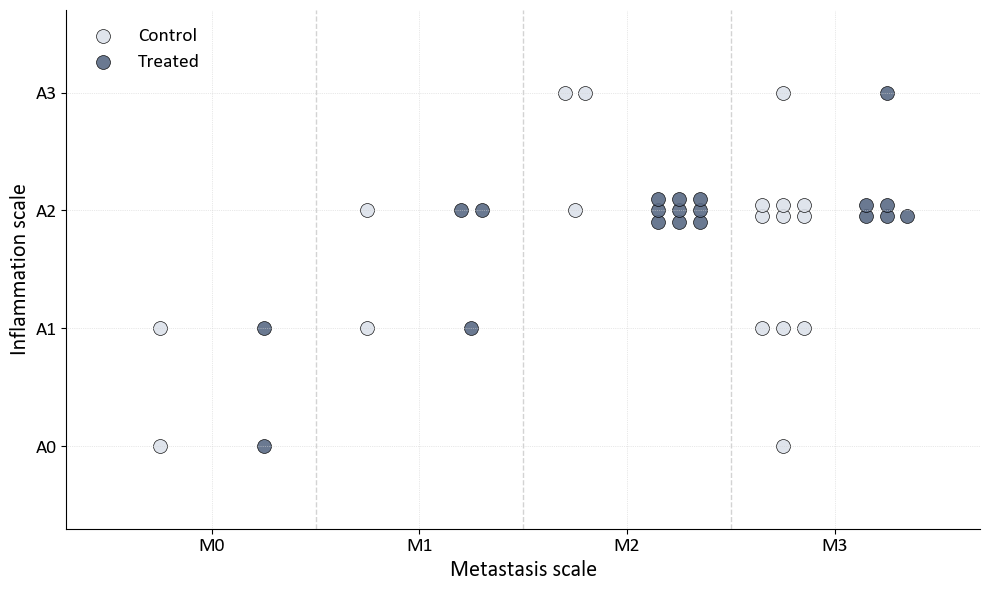

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
import seaborn as sns

# Set font for plots
plt.rcParams['font.family'] = 'Calibri'

# Load data
df = pd.read_excel("Tkanki klasyfikacja.xlsx")

# Remove mouse 311 (outlier or missing data)
df = df[df['Mouse number'] != 311]

# Define categorical order
metastasis_order = ['M0', 'M1', 'M2', 'M3']
inflammation_order = ['A0', 'A1', 'A2', 'A3']

# Convert to ordered categorical types
df['Metastasis stage'] = pd.Categorical(df['Liver metastases'], categories=metastasis_order, ordered=True)
df['Inflammation score'] = pd.Categorical(df['Liver abscesses'], categories=inflammation_order, ordered=True)
df['x_base'] = df['Metastasis stage'].cat.codes
df['y_base'] = df['Inflammation score'].cat.codes

# Apply group-based X position offset to separate Control and Treated within categories
group_offsets = {'Control': -0.25, 'Treated': 0.25}
df['x_offset'] = df['Group'].map(group_offsets)
df['x_pos'] = df['x_base'] + df['x_offset']

# Jitter points within grid cells (GraphPad-style scatter)
def grid_jitter(n, max_cols=3, jitter=0.1):
    cols = min(n, max_cols)
    rows = int(np.ceil(n / cols))
    x_jitter, y_jitter = [], []
    for i in range(n):
        col = i % cols
        row = i // cols
        x_j = (col - (cols - 1)/2) * jitter
        y_j = (row - (rows - 1)/2) * jitter
        x_jitter.append(x_j)
        y_jitter.append(y_j)
    return np.array(x_jitter), np.array(y_jitter)

# Apply jitter to all subgroups
df['x_jitter'], df['y_jitter'] = 0.0, 0.0
for (x_base, y_base, group), subdf in df.groupby(['x_base', 'y_base', 'Group']):
    x_j, y_j = grid_jitter(len(subdf))
    df.loc[subdf.index, 'x_jitter'] = x_j
    df.loc[subdf.index, 'y_jitter'] = y_j

# Final X and Y coordinates for scatter
df['x_final'] = df['x_pos'] + df['x_jitter']
df['y_final'] = df['y_base'] + df['y_jitter']

# Define color palette
palette = {"Control": "#DCE1EA", "Treated": "#5A6A85"}

# Plot
plt.figure(figsize=(10, 6))
for group in df['Group'].unique():
    sub = df[df['Group'] == group]
    plt.scatter(sub['x_final'], sub['y_final'],
                label=group, color=palette[group],
                edgecolor='black', s=100, alpha=0.9, linewidth=0.5)

# Axes setup
plt.xticks(ticks=range(len(metastasis_order)), labels=metastasis_order, fontsize=14)
plt.yticks(ticks=range(len(inflammation_order)), labels=inflammation_order, fontsize=14)
plt.xlabel('Metastasis scale', fontsize=16)
plt.ylabel('Inflammation scale', fontsize=16)
plt.xlim(-0.7, len(metastasis_order)-1 + 0.7)
plt.ylim(-0.7, len(inflammation_order)-0.3)

# OPTIONAL: Add Fisher’s exact test p-values by metastasis category
'''
for i, stage in enumerate(metastasis_order):
    stage_data = df[df['x_base'] == i]
    if stage_data['Group'].nunique() < 2:
        continue  # Skip if either group is missing

    def binarize_inflammation(subset):
        # A0 = no inflammation; A1–A3 = inflammation present
        inflamed = subset[subset['y_base'] > 0].shape[0]
        not_inflamed = subset[subset['y_base'] == 0].shape[0]
        return [inflamed, not_inflamed]

    control = stage_data[stage_data['Group'] == 'Control']
    treated = stage_data[stage_data['Group'] == 'Treated']

    if len(control) == 0 or len(treated) == 0:
        continue

    table = np.array([
        binarize_inflammation(control),
        binarize_inflammation(treated)
    ])

    # Check table shape before testing
    if table.shape == (2, 2) and table.sum() > 0:
        _, p = fisher_exact(table)
        plt.text(i, len(inflammation_order)-0.3, f"p = {p:.4f}", ha='center', fontsize=14)
'''

# Add vertical dashed lines between categories
for x in range(len(metastasis_order)-1):
    plt.axvline(x + 0.5, linestyle='--', color='lightgray', linewidth=1, zorder=0)

# Final plot styling
plt.legend(frameon=False, fontsize=14, loc='upper left')
plt.grid(True, linestyle=':', linewidth=0.5, color='lightgray')
sns.despine(top=True, right=True)
plt.tight_layout()

# Save plot (uncomment to use)
# plt.savefig('Inflammation score vs Metastasis score_no311.png', bbox_inches='tight', pad_inches=0.1)

plt.show()